# Setting up Mario

In [ ]:
# %pip install gym-super-mario-bros==7.4.0 nes_py

In [1]:
# Import the game
import gym_super_mario_bros

# Import Joypad wrapper
from nes_py.wrappers import JoypadSpace

# Import simplified control
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# for action error
import gym


# Create the environment

In [2]:
env = gym.make("SuperMarioBros-v0", apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env,SIMPLE_MOVEMENT)

/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [3]:
done = True
env.reset()
for step in range(50000):
    if done:
       env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = truncated or terminated
    env.render()

    

env.close()

/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


KeyboardInterrupt: 

# Pre-processing

We need to pre process the environment before we can make the RL learn it. To pre process it - gray scaling and frame stacking. Take the images and convert it to gray scale inorder to cut down the data it learns. Frame stacking helps determine the trajectory and velocity. We stack multiple frames to store it into the memory - see mario and enemy movements.

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [4]:
# install stable baseline for RL
%pip install stable-baselines3[extra]

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Frame stacking wrapper and gray scaling wrapper
from gym.wrappers import GrayScaleObservation

# Import Vectorization wrapper
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Import matplotlib
from matplotlib import pyplot as plt

In [4]:
# create the env
env = gym.make("SuperMarioBros-v0", apply_api_compatibility=True, render_mode="human")

# simplify the control
env = JoypadSpace(env,SIMPLE_MOVEMENT)

#grayscale
env = GrayScaleObservation(env,keep_dim=True)

# wrap the dummy env
env = DummyVecEnv([lambda:env])

# stack the frame 
env = VecFrameStack(env,4,channels_order="last")

/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [5]:
state = env.reset()

In [6]:
action = env.action_space.sample()
state, reward, terminated,  info = env.step([action])

/home/sukruthi/Desktop/RL-for-Super-Mario/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


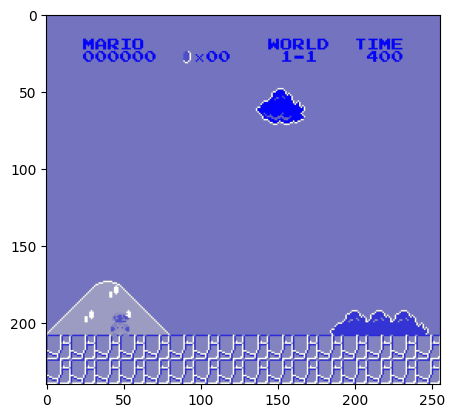

In [7]:
# using matplotlib to get 
plt.imshow(state[0])

In [35]:
state,reward,done,info = env.step([5])

<function matplotlib.pyplot.show(close=None, block=None)>

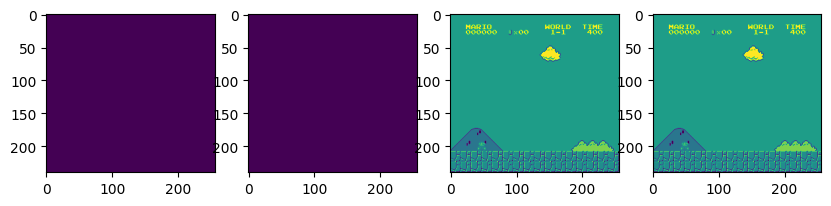

In [8]:
plt.figure(figsize=(10,8))
for idx in range (state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show

# Train RL model

In [9]:
import os

# PPO algorithm
from stable_baselines3 import PPO

# Base callback to save models
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [18]:
CHECKPOINT_DIR = '.train2000000_lr_1e-5'
LOG_DIR = '.logs2000000_lr_1e-5'

In [19]:
# callback to save model
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

In [20]:
# initiate RL model
# model = PPO()
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,
            n_steps=512, batch_size=64) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [23]:
model.learn(total_timesteps=2000000, callback=callback)

Logging to .logs2000000_lr_1e-5/PPO_3
----------------------------
| time/              |     |
|    fps             | 194 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 134           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.2142347e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.000486      |
|    learning_rate        | 1e-06         |
|    loss                 | 188           |
|    n_updates            | 47            |
|    policy_gradient_loss | -7.47e-06     |
|    value_loss           | 487           |
-----------

In [11]:
model.save('thisisatestmodel')

NameError: name 'model' is not defined

# Testing

In [14]:
# load the last trained model
model = PPO.load('/home/sukruthi/Desktop/RL-for-Super-Mario/.train2000000_lr_1e-5/best_model_1220000')

In [15]:
# start super mario
state = env.reset()

# 
while True:
    action,_ = model.predict(state)
    state,reward,done,info = env.step(action)
    env.render

KeyboardInterrupt: 